In [1]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

import swifter
import spacy
import ssl
from spacy import displacy
import pandas as pd
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from sklearn.metrics import accuracy_score
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from fuzzywuzzy import process, fuzz

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
stop=set(stopwords.words('english'))
#nltk.download('stopwords')

from joblib import Parallel, delayed

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

import seaborn as sns

import re

# EDA - Exploratory Data Anaysis
- Importing the original dataset
- Checking the number of rows and columns of the dataset
- Checking the total of null values per columns
- Checking the total of unique values per column

In [2]:
#df = pd.read_parquet('C:/Users/Olimpio.Dasilva/Desktop/MACHINE LEARNING/DATA/reporting_ncr_all_transactions_202302131044.parquet')
df = pd.read_csv('C:/Users/Olimpio.Dasilva/Desktop/random_sampling/reporting_ncr_all_transactions_202303081506.csv')
#df = pd.read_csv('C:/Users/Olimpio.Dasilva/Desktop/random_sampling/reporting_ncr_all_transactions_202303081406.csv')
pd.set_option('display.max_colwidth', None)
df = df.sample(25000)
df.head(5)

,fi_id,account_id,transaction_id,amount,currency,txn_desc1,txn_desc2,region,transaction_timestamp,merchant_id,merchant_name,payment_agent,payment_agent_id,extract_date,filename,name
330023,DI1425,A5d3d28bde26e398689d22c0ba70392fb,T0b982f74d5eb3b8bac151c434ce6be18,18.00,USD,Withdrawal Debit 7-ELEVEN,ORLANDO FLUS,NaN,2023-01-25,10012.0,7 ELEVEN,Unknow Payment Agent,NaN,2023-01-28,FTS_CSLK_TRANSAC_20230127_100006.csv,Fairwinds Credit Union
35352,DI3658,A298346bb65943ae7bf6f64518eea8de3,Tb39fb773a3e83f3d9efc1332550a32b6,6.26,USD,Point Of Sale Withdrawal,PP*DUTCHBROSEA VANCOUVER WAUS,NaN,2022-11-17,13706.0,DUTCH BROS. COFFEE,Unknow Payment Agent,NaN,2022-11-26,FTS_CSLK_TRANSAC_20221125_100006.csv,COLUMBIA CREDIT UNION
100035,DI9094,Af0a5686bc46a37d8842272a2b0ea6d8b,Tfb58495d82803f14ac7320fce42b682e,25.00,USD,POS Withdrawal E-Z*PASSNY,REBILL 800-333-8655 NYUS,NaN,2022-09-08,11017.0,EZPASS PREPAID TOLL,Unknow Payment Agent,NaN,2022-09-11,FTS_CSLK_TRANSAC_20220910_100006.csv,Service Federal Credit Union
546877,DI3337,Aed5291811f133717bd66193093841cfd,T711e5c8bb27e3a47ae11738cfd478dec,14.11,USD,Withdrawal #**,WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ,AZ,2022-11-16,13085.0,WALMART,Unknow Payment Agent,NaN,2022-11-20,FTS_CSLK_TRANSAC_20221119_100006.csv,Arizona Federal Credit Union
1181491,DI3468,A73aec1ae3f443ed7a110a332a7d2d2da,T4f6a1417bf0a320cb3c9ab79edd1fbd7,24.87,USD,DEBIT CARD DEBIT,02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127,NaN,2023-02-27,12466.0,SCHNUCKS MARKET,Unknow Payment Agent,NaN,2023-03-01,FTS_CSLK_TRANSAC_20230228_100007.csv,Neighbors Credit Union


In [3]:
print('Total number of rows and columns:', df.shape)

Total number of rows and columns: (25000, 16)


In [4]:
print('Total number of null values per column:')
df.isnull().sum()
#df.dropna(inplace=True)

Total number of null values per column:


fi_id                        0
account_id                   0
transaction_id               0
amount                       0
currency                     0
txn_desc1                    0
txn_desc2                 2051
region                   21208
transaction_timestamp        0
merchant_id                  0
merchant_name                0
payment_agent                0
payment_agent_id         23729
extract_date                 0
filename                     0
name                         0
dtype: int64

In [5]:
print('Total number of unique values per column:')
df.nunique()

Total number of unique values per column:


fi_id                      176
account_id               20542
transaction_id           24999
amount                    8945
currency                     1
txn_desc1                 7778
txn_desc2                20006
region                      49
transaction_timestamp      527
merchant_id                864
merchant_name              866
payment_agent               14
payment_agent_id            27
extract_date               502
filename                   554
name                       176
dtype: int64

# Unknown Merchant Names
- Selecting dataset with unknown merchants only
- Checking the number of rows and columns

In [6]:
df_unknown_merchs = df.copy(deep=True)
df_unknown_merchs = df_unknown_merchs[df["merchant_name"].str.contains("Unknow Merchant") == True]
print('Total number of rows and columns:', df_unknown_merchs.shape)

Total number of rows and columns: (0, 16)


# Known Merchant Names
- Selecting known merchants only 
- Checking the number of rows/transactions
- Checking the total number of merchants
- Checking the total number of occurrences per merchant
- Concatenated the transaction details columns
- Defined a function for word cloud for top merchants
- Defined a function for N-gram for top merchants with combined names
- Defined a function to check occurence of merchants in transaction columns

In [7]:
# Selecting only known merchants names from the original dataset
df_known_merchs = df[['transaction_id','txn_desc1','txn_desc2','payment_agent','merchant_name']].copy(deep=True)
df_known_merchs = df_known_merchs[df["merchant_name"].str.contains("Unknow Merchant") == False]
#######
df_known_merchs_cp2 = df[['transaction_id','txn_desc1','txn_desc2','payment_agent','merchant_name']].copy(deep=True)
df_known_merchs_cp2 = df_known_merchs_cp2[df["merchant_name"].str.contains("Unknow Merchant") == False]

#df_known_merchs = df_known_merchs.head(50)

In [8]:
print('Number of transactions with known merchant names:\n',len(df_known_merchs) )

Number of transactions with known merchant names:
 25000


In [9]:
print('Total number of known merchants:\n',len(df_known_merchs.merchant_name.unique()))

Total number of known merchants:
 866


In [10]:
print('Total number of occurences per merchant name:\n',(df_known_merchs.merchant_name).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Total number of occurences per merchant name:
 AMAZON.COM         8.5%
WALMART            6.9%
MCDONALD'S         3.2%
APPLE STORE        2.9%
TARGET             2.3%
                   ... 
LOWE'S FOODS       0.0%
GOLDEN CHICK       0.0%
COUNTRY KITCHEN    0.0%
CHLOE              0.0%
ROY'S              0.0%
Name: merchant_name, Length: 866, dtype: object


In [11]:
# Concatenating transaction descriptions columns
df_known_merchs["TRANSACTION_DETAILS"] = df_known_merchs['txn_desc1'].astype(str) +" %%%%% "+ df_known_merchs['txn_desc2'].astype(str)

In [12]:
df_known_merchs.head(5)

,transaction_id,txn_desc1,txn_desc2,payment_agent,merchant_name,TRANSACTION_DETAILS
330023,T0b982f74d5eb3b8bac151c434ce6be18,Withdrawal Debit 7-ELEVEN,ORLANDO FLUS,Unknow Payment Agent,7 ELEVEN,Withdrawal Debit 7-ELEVEN %%%%% ORLANDO FLUS
35352,Tb39fb773a3e83f3d9efc1332550a32b6,Point Of Sale Withdrawal,PP*DUTCHBROSEA VANCOUVER WAUS,Unknow Payment Agent,DUTCH BROS. COFFEE,Point Of Sale Withdrawal %%%%% PP*DUTCHBROSEA VANCOUVER WAUS
100035,Tfb58495d82803f14ac7320fce42b682e,POS Withdrawal E-Z*PASSNY,REBILL 800-333-8655 NYUS,Unknow Payment Agent,EZPASS PREPAID TOLL,POS Withdrawal E-Z*PASSNY %%%%% REBILL 800-333-8655 NYUS
546877,T711e5c8bb27e3a47ae11738cfd478dec,Withdrawal #**,WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ,Unknow Payment Agent,WALMART,Withdrawal #** %%%%% WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,DEBIT CARD DEBIT,02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127,Unknow Payment Agent,SCHNUCKS MARKET,DEBIT CARD DEBIT %%%%% 02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127


In [13]:
def word_cloud(a):
    # Word cloud for more frequent merchant names
    text = " ".join(i for i in a)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(7,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

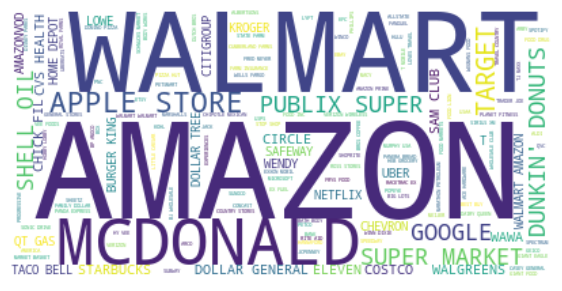

In [14]:
# Copy of the afs merchant names column
df_known_merchs['AFS_PAYMENT_AGENTS'] = df_known_merchs['payment_agent'] 
# Copy of the afs merchant names column
df_known_merchs['AFS_MECHANT_NAMES'] = df_known_merchs['merchant_name']
# Droping original cols
df_known_merchs = df_known_merchs.drop(['txn_desc1', 'txn_desc2','payment_agent','merchant_name'], axis=1)

# Word cloud for more frequent merchant names
word_cloud(df_known_merchs.AFS_MECHANT_NAMES)

In [15]:
df_known_merchs

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES
330023,T0b982f74d5eb3b8bac151c434ce6be18,Withdrawal Debit 7-ELEVEN %%%%% ORLANDO FLUS,Unknow Payment Agent,7 ELEVEN
35352,Tb39fb773a3e83f3d9efc1332550a32b6,Point Of Sale Withdrawal %%%%% PP*DUTCHBROSEA VANCOUVER WAUS,Unknow Payment Agent,DUTCH BROS. COFFEE
100035,Tfb58495d82803f14ac7320fce42b682e,POS Withdrawal E-Z*PASSNY %%%%% REBILL 800-333-8655 NYUS,Unknow Payment Agent,EZPASS PREPAID TOLL
546877,T711e5c8bb27e3a47ae11738cfd478dec,Withdrawal #** %%%%% WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ,Unknow Payment Agent,WALMART
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,DEBIT CARD DEBIT %%%%% 02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127,Unknow Payment Agent,SCHNUCKS MARKET
...,...,...,...,...
430174,T507ed65025883d7f92459be3636e8992,POS SPEEDWAY 07166 121MOUNT %%%%% JULIET TNUS,Unknow Payment Agent,SPEEDWAY
701314,T4e2ffd7530c83de18498c93b754fabad,Withdrawal #** %%%%% TARGET T-1209 1515 E Warner Rd Gilbert AZ,Unknow Payment Agent,TARGET
350628,Td0680f96fb433d259a75caa080515491,Withdrawal WAL WAL-MART #0649 %%%%% * TITUSVILLE US %% Card 25 #2893 %% MCC 5411 #*,Unknow Payment Agent,WALMART
1103034,Tc05cf482672d3159946808a4eb0dadad,WITHDRAWAL %%%%% POS 1224 1240 * WM SUPERCENTER # PHENIX CITY AL,Unknow Payment Agent,WALMART


In [16]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

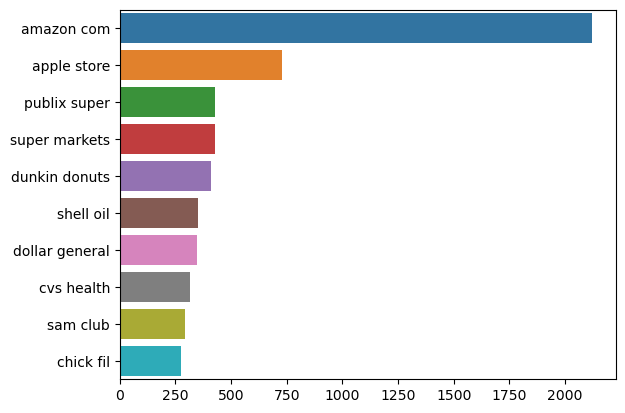

In [17]:
top_n_bigrams=get_top_ngram(df_known_merchs['AFS_MECHANT_NAMES'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x);

In [18]:
def check_names(merchant, t_details):
    
    # Variations for merchant name column
    merchant_1 = merchant
    merchant_2 = merchant_1.lower()
    merchant_3 = re.sub("[\\\\/:*?'#<>|-]", '', merchant_2)
    merchant_4 = re.sub(' ', '', merchant_2)
    merchant_5 = re.sub('[.com/]', ' ', merchant_2)
    merch_list = merchant_1.split() + merchant_2.split() + merchant_3.split() + merchant_4.split() + merchant_5.split() + merchant.split()
    
    # Variations for transaction details column
    t_details_1 = t_details
    t_details_2 = t_details.lower()
    t_details_3 = re.sub("[\\\\/:*?'#<>|-]", '', t_details_2)
    t_details_4 = re.sub("[.com/]", " ",t_details_2)
    t_details_5 = re.sub("[\\\\/:*?'#<>|-]", ' ', t_details_2)
    
    # Merchants mentioned in transaction description w/ variations
    comp_1 = re.sub("Prime", "AMAZONVOD",t_details_1)
    comp_2 = re.sub("VZWRLSS", "VERIZON WIRELESS",t_details_1)
    comp_3 = re.sub("WM", "WALMART",t_details_1)
    
    # Creating a list of conversions to check if merchants are mentioned in transation descriotions 
    details_lis = t_details_2.split()
    details_lis_1 = t_details_1.split() + t_details_2.split() + t_details_3.split() + details_lis + t_details_4.split() + t_details_5.split() + comp_1.split() + comp_2.split() + comp_3.split() + t_details.split()
    
    # Conditions to check if words are in transaction strings
    if (merchant in t_details_3 or t_details_3 in merchant or 
        (merchant_2 in t_details_3 or t_details_3 in merchant_2) or 
        (merchant_3 in t_details_3 or t_details_3 in merchant_3) or
        (merchant_4 in t_details_3 or t_details_3 in merchant_4) or
        (merchant_1 in t_details_3 or t_details_1 in merchant_4) or
        (merchant_1 in details_lis_1 or merchant_4 in details_lis)or
        (any(item in merch_list for item in details_lis_1)) or
        (merchant_1[:4] in t_details_1)):
        return True
    else:
        return False
    

- Checked the occurrence of merchants in the first and secod transation colums separately
- Checked the total number of occurrences per column

In [19]:
# Merchants in the txt_1 or txt_2 columns
df_known_merchs_cp2['txn_desc2'] = df_known_merchs_cp2['txn_desc2'].astype(str)
df_known_merchs_cp2['txn_desc1'] = df_known_merchs_cp2['txn_desc1'].astype(str)
df_known_merchs_cp2['merchant_name'] = df_known_merchs_cp2['merchant_name'].astype(str)
df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] = df_known_merchs_cp2.apply(lambda x: check_names(x.merchant_name, x.txn_desc1), axis=1) # OR txn_desc2
df_known_merchs_cp2.head(5)

,transaction_id,txn_desc1,txn_desc2,payment_agent,merchant_name,CHECK_MERCH_TRA_cp
330023,T0b982f74d5eb3b8bac151c434ce6be18,Withdrawal Debit 7-ELEVEN,ORLANDO FLUS,Unknow Payment Agent,7 ELEVEN,True
35352,Tb39fb773a3e83f3d9efc1332550a32b6,Point Of Sale Withdrawal,PP*DUTCHBROSEA VANCOUVER WAUS,Unknow Payment Agent,DUTCH BROS. COFFEE,False
100035,Tfb58495d82803f14ac7320fce42b682e,POS Withdrawal E-Z*PASSNY,REBILL 800-333-8655 NYUS,Unknow Payment Agent,EZPASS PREPAID TOLL,False
546877,T711e5c8bb27e3a47ae11738cfd478dec,Withdrawal #**,WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ,Unknow Payment Agent,WALMART,False
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,DEBIT CARD DEBIT,02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127,Unknow Payment Agent,SCHNUCKS MARKET,False


In [20]:
print('Total of transactions with known merchants:\n',len(df_known_merchs_cp2))

Total of transactions with known merchants:
 25000


In [21]:
print('Merchant name occurrence in txn_desc1 column:\n',(df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] == True).sum())

Merchant name occurrence in txn_desc1 column:
 10668


In [22]:
df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] = df_known_merchs_cp2.apply(lambda x: check_names(x.merchant_name, x.txn_desc2), axis=1)
print('Merchant name occurrence in txn_desc2 column:\n',(df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] == True).sum())

Merchant name occurrence in txn_desc2 column:
 17509


- Checked occurrence of merchants in concatenated transaction column
- Created CHECK_MERCH_TRA to inspect occurrences
- Checked total number of occurences in merchant details coolumn

In [23]:
# Checking if merchant names are mentioned in the transaction description
df_known_merchs['CHECK_MERCH_TRA'] = df_known_merchs.apply(lambda x: check_names(x.AFS_MECHANT_NAMES, x.TRANSACTION_DETAILS), axis=1)
df_known_merchs.head(5)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
330023,T0b982f74d5eb3b8bac151c434ce6be18,Withdrawal Debit 7-ELEVEN %%%%% ORLANDO FLUS,Unknow Payment Agent,7 ELEVEN,True
35352,Tb39fb773a3e83f3d9efc1332550a32b6,Point Of Sale Withdrawal %%%%% PP*DUTCHBROSEA VANCOUVER WAUS,Unknow Payment Agent,DUTCH BROS. COFFEE,True
100035,Tfb58495d82803f14ac7320fce42b682e,POS Withdrawal E-Z*PASSNY %%%%% REBILL 800-333-8655 NYUS,Unknow Payment Agent,EZPASS PREPAID TOLL,False
546877,T711e5c8bb27e3a47ae11738cfd478dec,Withdrawal #** %%%%% WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ,Unknow Payment Agent,WALMART,True
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,DEBIT CARD DEBIT %%%%% 02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127,Unknow Payment Agent,SCHNUCKS MARKET,True


In [24]:
# Merchant name in the transaction description
print('Merchant name in the transaction description:\n',(df_known_merchs['CHECK_MERCH_TRA'] == True).sum() )

Merchant name in the transaction description:
 24646


- Created a copy to encode CHECK_MERCH_TRA results
- Created a chart to compare the results
- Created a word cloud of AFS_MECHANT_NAMES to get most frequen merchants
- Checked how many times merchants are mentioned in transaction details
- Checked how many times merchants are not in transaction details
- Created word cloud for merchants not in transaction details 

In [25]:
df_known_merchs_cp = df_known_merchs[['transaction_id','TRANSACTION_DETAILS','AFS_PAYMENT_AGENTS','AFS_MECHANT_NAMES','CHECK_MERCH_TRA']].copy(deep=True)
df_known_merchs_cp.head()

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
330023,T0b982f74d5eb3b8bac151c434ce6be18,Withdrawal Debit 7-ELEVEN %%%%% ORLANDO FLUS,Unknow Payment Agent,7 ELEVEN,True
35352,Tb39fb773a3e83f3d9efc1332550a32b6,Point Of Sale Withdrawal %%%%% PP*DUTCHBROSEA VANCOUVER WAUS,Unknow Payment Agent,DUTCH BROS. COFFEE,True
100035,Tfb58495d82803f14ac7320fce42b682e,POS Withdrawal E-Z*PASSNY %%%%% REBILL 800-333-8655 NYUS,Unknow Payment Agent,EZPASS PREPAID TOLL,False
546877,T711e5c8bb27e3a47ae11738cfd478dec,Withdrawal #** %%%%% WAL Wal-Mart Super * 1218 WAL-SAMS CASA GRANDE AZ,Unknow Payment Agent,WALMART,True
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,DEBIT CARD DEBIT %%%%% 02-25-2023 SCHNUCKS LINDENW SC ST. CHARLES MO auth #51127,Unknow Payment Agent,SCHNUCKS MARKET,True


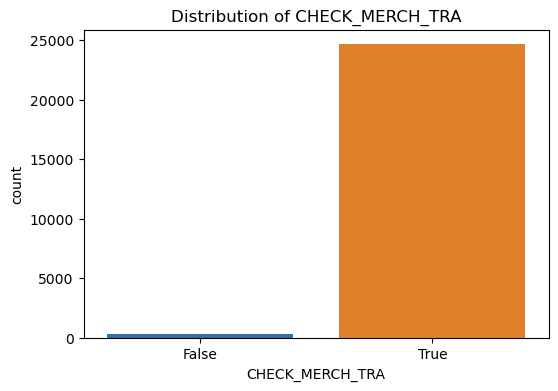

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(x="CHECK_MERCH_TRA", data=df_known_merchs_cp)
plt.title("Distribution of CHECK_MERCH_TRA");

In [27]:
print('Percentage of merchant names in T details or not (1/0):\n',(df_known_merchs_cp.CHECK_MERCH_TRA).value_counts(normalize=True).mul(100).round(1).astype(str) + '%');

Percentage of merchant names in T details or not (1/0):
 True     98.6%
False     1.4%
Name: CHECK_MERCH_TRA, dtype: object


In [28]:
# Number of merchant names in transaction details
df_check_true = pd.DataFrame()
df_check_true = df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA'] == True]
print('Number of merchant names in transaction details:\n',len(df_check_true))

Number of merchant names in transaction details:
 24646


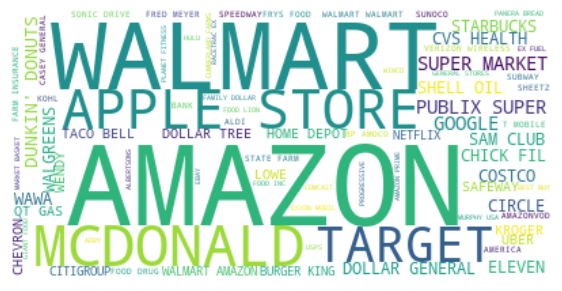

In [29]:
# Word cloud for more frequent merchant names WHEN merchant name is in transaction description

word_cloud(df_check_true.AFS_MECHANT_NAMES)

In [30]:
print('Total number of occurences per merchant name:\n',(df_check_true.AFS_MECHANT_NAMES).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Total number of occurences per merchant name:
 AMAZON.COM      8.5%
WALMART         7.0%
MCDONALD'S      3.3%
APPLE STORE     2.9%
TARGET          2.3%
                ... 
CHLOE           0.0%
HINGE           0.0%
LOWE'S FOODS    0.0%
EPIC GAMES      0.0%
ROY'S           0.0%
Name: AFS_MECHANT_NAMES, Length: 857, dtype: object


In [31]:
print('Number of merchant names NOT in the transaction description:\n',(df_known_merchs['CHECK_MERCH_TRA'] == False).sum())

Number of merchant names NOT in the transaction description:
 354


In [32]:
# Number of merchant names not in transaction details
df_check_false = pd.DataFrame()
df_check_false = df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA'] == False]
#print('Number of merchant names NOT in the transaction description:\n', len(df_check_false))

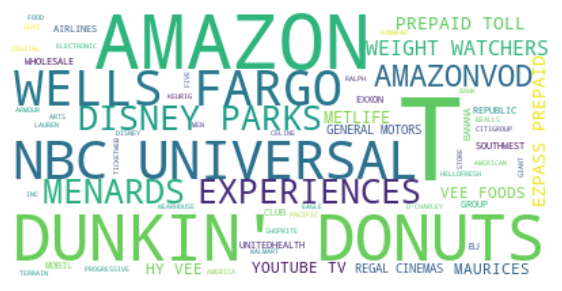

In [33]:
# Word cloud for more frequent merchant names WHEN merchant name is NOT in transaction description
word_cloud(df_check_false.AFS_MECHANT_NAMES)

In [34]:
print('Total number of occurences per merchant name WHEN merchant name is NOT in transation details:\n', (df_check_false.AFS_MECHANT_NAMES).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Total number of occurences per merchant name WHEN merchant name is NOT in transation details:
 AT&T                            35.9%
AMAZON.COM                      10.7%
DUNKIN' DONUTS                   8.2%
NBC UNIVERSAL                    6.5%
WELLS FARGO                      5.4%
DISNEY PARKS AND EXPERIENCES     5.1%
MENARDS                          5.1%
AMAZONVOD                        4.0%
WEIGHT WATCHERS                  2.3%
EZPASS PREPAID TOLL              1.7%
METLIFE                          1.4%
YOUTUBE TV                       1.1%
HY-VEE-FOODS                     1.1%
MAURICES                         1.1%
REGAL CINEMAS                    0.8%
GENERAL MOTORS                   0.8%
BJ'S WHOLESALE CLUB              0.6%
UNITEDHEALTH GROUP               0.6%
EXXON MOBIL                      0.6%
SOUTHWEST AIRLINES               0.6%
BANANA REPUBLIC                  0.6%
CELINE                           0.3%
KEURIG                           0.3%
TICKETWEB                      

- Merchant names not mentioned in transaction description

In [35]:
# Merchant names not mentioned in transaction description
df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA']==False] 


,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
100035,Tfb58495d82803f14ac7320fce42b682e,POS Withdrawal E-Z*PASSNY %%%%% REBILL 800-333-8655 NYUS,Unknow Payment Agent,EZPASS PREPAID TOLL,False
17781,Te963e02eb7f73626b1c472ba60247cc0,POS Withdrawal (FIS) AT+T %%%%% *PAYMENT AT+T *PAYMENT 800-288-2020 FL(8302),Unknow Payment Agent,AT&T,False
418140,T436c51d8bd893ca4a444660b84fd23be,POS Withdrawal (FIS) WDW %%%%% AMORETTE'S WDW AMORETTE'S LAKE BUENA VI FL(6571),Unknow Payment Agent,DISNEY PARKS AND EXPERIENCES,False
538670,Te3bec864e33c314ab1233c64dc520af6,WITHDRAW %%%%% POS 0316 1543 * GM Financial Arlington TX,Unknow Payment Agent,GENERAL MOTORS,False
485737,Td1beb9ce7edf34c69d66f4798a15453f,External Withdrawal ATT - %%%%% Payment,Unknow Payment Agent,AT&T,False
...,...,...,...,...,...
1162322,Td9bfd7170da03b02b9505dfac1164a71,Withdrawal MCSIGNATURE %%%%% Kindle Unltd*4311N76T3 866-321-8851 WA Date 07/19/22 ***43281 5818 %% Card 20 #9565,Unknow Payment Agent,AMAZON.COM,False
1434052,T9579aa9e22aa3899a986edce329f3830,Withdrawal ATT %%%%% TYPE: Payment ID: *1005 CO: ATT NAME: ABBE GODSEY %% ACH Trace **563,Unknow Payment Agent,AT&T,False
27971,T4e853c2cb2e9348fb1f59978d408e90b,Withdrawal ATT %%%%% TYPE: Payment ID: *1005 CO: ATT NAME: BANK,Unknow Payment Agent,AT&T,False
1302562,Tf64225fb862b34f0b173d0827333dd06,Withdrawal Debit ATT* BILL %%%%% PAYMENT 800-331-0500 TXUS,Unknow Payment Agent,AT&T,False


# Named Entity Recognition
- Created a copy of df_known_merchs for predictions purposes - "df_known_merchs_pred"
- Created the PREDICTIONS column
- Used NER from Spacy
- Applied Entity Ruler to add all the merchants (PATTERNS) from AFS into the model
- Defined function to find patterns from AFS predictions - "def_patterns"
- Defined function to find the organisations in the Transaction details column - "find_org"
- Defined funtion to implement parallel processing = "find_org_parallel"
- Implemented cust NER model and displayed the results

In [36]:
df_known_merchs_pred = df_known_merchs.copy(deep=True)
df_known_merchs_pred['AFS_MECHANT_NAMES'] = df_known_merchs_pred['AFS_MECHANT_NAMES'].str.lower()
df_known_merchs_pred['TRANSACTION_DETAILS']= df_known_merchs_pred['TRANSACTION_DETAILS'].str.lower().str.replace(r'\s{2,}','').str.replace(r"[,;@#?!&$*]+\ *", " ")

In [37]:
df_known_merchs_pred.head(10)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
330023,T0b982f74d5eb3b8bac151c434ce6be18,withdrawal debit 7-eleven %%%%% orlando flus,Unknow Payment Agent,7 eleven,True
35352,Tb39fb773a3e83f3d9efc1332550a32b6,point of sale withdrawal %%%%% pp dutchbrosea vancouver waus,Unknow Payment Agent,dutch bros. coffee,True
100035,Tfb58495d82803f14ac7320fce42b682e,pos withdrawal e-z passny %%%%% rebill 800-333-8655 nyus,Unknow Payment Agent,ezpass prepaid toll,False
546877,T711e5c8bb27e3a47ae11738cfd478dec,withdrawal %%%%% wal wal-mart super 1218 wal-sams casa grande az,Unknow Payment Agent,walmart,True
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,debit card debit %%%%% 02-25-2023 schnucks lindenw sc st. charles mo auth 51127,Unknow Payment Agent,schnucks market,True
283969,Tb496e2d37c02383fb9cc63358d5307a9,pos transaction %%%%% american eagle grove city paus,Unknow Payment Agent,american eagle,True
1178461,T32cd3a0fff0133f884094cec1382ffad,ach withdrawal travelers - per %%%%% insur,Unknow Payment Agent,traveler's insurance,True
1377488,Te9a5a4ec3e383aa3980c258549a011de,pos withdrawal (fip) bjs whole %%%%% 115 e bjs whole 115 erdma leominister ma(8297),Unknow Payment Agent,bj's wholesale club,True
1407191,T337cf950f007316d97ac8d529c9aa3d3,pos debit 2050 01/31 11:32 wal wal-ma rt sup south hill va %%%%% nan,Unknow Payment Agent,walmart,True
1363491,T6d08cee34f073fc993d1c5fab557a015,withdrawal %%%%% dollar ge dg 775 awendaw sc %% card 15 2224,Unknow Payment Agent,dollar general,True


- Function to find and create a list of patterns

In [38]:
def def_patterns(a):

    #Creating a list of patterns - with all the merchant names (with and without spaces, quotes, .com, etc.)

    org =  a #df_known_payment_agents['AFS_MECHANT_NAMES']

    #List of Entities and Patterns
    org_list = org.tolist()

    a = [ x.strip() for x in org_list] # list comprehension - all merchant names from original org_list
    a_space =list(filter(lambda x: ' ' in x, a)) # filtering all names w spaces
    a_nospace = [x.replace(' ', '') for x in a_space] # replacing spaces w ''

    a_quo =list(filter(lambda x: "'" in x, a)) # filtering all names w quotes
    a_noquuo = [x.replace("'", '') for x in a_quo] # replacing quotes w ''

    a_com =list(filter(lambda x: '.com' in x, a)) # filtering all names w .com
    a_nocom = [x.replace('.com', '') for x in a_com] # replacing .com w ''

    a_dash =list(filter(lambda x: '-' in x, a)) # filtering all names w dash
    a_nodash = [x.replace('-', '') for x in a_com] # replacing dash w ''

    new_lis = a + a_nospace + a_nocom + a_noquuo + a_nodash # add instead of dis_list


    # Creating a list of patterns with all the variations from new_lis
    patterns = []
    i = 0
    new_lis = tuple(new_lis)
    for item in new_lis:
        patterns.append({"label": 'ORG', "pattern": [{"LOWER":item}]})
        # patterns.append({"label": 'ORG', "pattern": new_lis[i]})
        i+=1

    # #print(patterns)
    #patterns.append(listb)
    #print(patterns)


    return patterns

In [39]:
patterns = def_patterns(df_known_merchs_pred['AFS_MECHANT_NAMES'])

- Function to find organisations using patterns

In [40]:
# Function to find merchant names in a string - using an NER model with the previously created patterns

def find_org(text:str):
    
    #Build upon the spaCy Model
    NER2 = spacy.load("en_core_web_sm")
    
    #Create the EntityRuler
    ruler = NER2.add_pipe("entity_ruler", config={'validate': True})
     
    ruler.add_patterns(patterns)
    doc_ner = NER2(text)
    
    # useless strings
    junk = ['fip', 'ca(2810','fis','xx4386', '#185','*','hr0d','k50ms3hv','xx9510','xx4710','xx4706','xx0322','he34i8pz0','xx3840','pd1387','ma(9661','ns4qa9xb3 ']
    
    #extract entities
    orgs = []
    for ent in doc_ner.ents:
        if ((ent.label_ == "ORG") and (ent.text not in junk)):
            orgs.append(ent.text)
    orgs = list(set(orgs))
    return ' '.join(orgs) if orgs else 'NA'

- Function for parallel processing

In [41]:
def find_org_parallel(a:dict):
    i=a.copy()
    print(i)
    result = find_org(i['TRANSACTION_DETAILS'])
    i['PREDICTIONS']= result
    print(i)
    return i

In [42]:
df_known_merchs_pred.head(5)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
330023,T0b982f74d5eb3b8bac151c434ce6be18,withdrawal debit 7-eleven %%%%% orlando flus,Unknow Payment Agent,7 eleven,True
35352,Tb39fb773a3e83f3d9efc1332550a32b6,point of sale withdrawal %%%%% pp dutchbrosea vancouver waus,Unknow Payment Agent,dutch bros. coffee,True
100035,Tfb58495d82803f14ac7320fce42b682e,pos withdrawal e-z passny %%%%% rebill 800-333-8655 nyus,Unknow Payment Agent,ezpass prepaid toll,False
546877,T711e5c8bb27e3a47ae11738cfd478dec,withdrawal %%%%% wal wal-mart super 1218 wal-sams casa grande az,Unknow Payment Agent,walmart,True
1181491,T4f6a1417bf0a320cb3c9ab79edd1fbd7,debit card debit %%%%% 02-25-2023 schnucks lindenw sc st. charles mo auth 51127,Unknow Payment Agent,schnucks market,True


In [43]:
t_list = df_known_merchs_pred[['transaction_id', 'TRANSACTION_DETAILS', 'AFS_MECHANT_NAMES', 'CHECK_MERCH_TRA']].copy(deep=True).to_dict(orient='records') #replace similarity w unique ID

In [44]:
# df_known_merchs_pred['PREDICTIONS'] = df_known_merchs_pred.TRANSACTION_DETAILS.swifter.apply(find_org)

In [45]:
par = Parallel(n_jobs=-1)(delayed(find_org_parallel)(i) for i in tqdm(t_list))

100%|██████████| 25000/25000 [5:03:56<00:00,  1.37it/s]  


In [46]:
df_known_merchs_pred = pd.DataFrame(par)

- Function to compare results - True/False

In [47]:
def check_names_pred(a, b):
    if ((a in b) or (b in a)):
        return True
    elif (fuzz.ratio(a, b) > 92):
        return True
    else:
        return False

- NER predictions using Spacy and Entity Ruler technique

In [63]:
df_known_merchs_pred['CHECK_TF'] = df_known_merchs_pred.apply(lambda x: check_names(x.AFS_MECHANT_NAMES, x.PREDICTIONS), axis=1)
df_known_merchs_pred.sample(10)

,transaction_id,TRANSACTION_DETAILS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,PREDICTIONS,CHECK_TF
19026,T8f70be01b3873699917332e0a68e30a4,publix 12681 miramar %%%%% parkw miramar flus : pos transaction,publix super markets,True,NA,False
19269,T92a7cb2afb3932539ee894c906375dd0,withdrawal wal-mart super %%%%% center west melbourn us %% card 25 2705 %% mcc 5411,walmart,True,wal-mart,True
8865,T39f0388d8a223702b12151e9bc7a2838,withdrawal %%%%% sheetz 0379 moon township pa %% card 20 3034,sheetz,True,sheetz,True
19704,Tb6459dccd59b3f329c6c340593ff38d2,debit card debit %%%%% auth 01-08-2023 grubhubbabasstea 1085 ny,grubhub.com,True,NA,False
4736,T7ef52956a83233a2bc238d095c689daa,withdrawal debit circle k %%%%% 01733 200 che titusville flus,circle k,True,NA,False
1169,T55aa095df4a637f894745945e3dc1831,withdrawal %%%%% dollartree 1226 s rainbow blvd las vegas nv %% card 25 6194 terminal: 01,rainbow foods,True,dollartree,False
6686,Tb396a9c478323eca89523bb752ea1c8a,debit card debit %%%%% auth 02-13-2023 wal-mart store 2009 wal-sams abingdon md,walmart,True,wal-mart,True
19310,T2fdc34f92ece36c387b86427f4c6f1e6,withdrawal signature debit %%%%% dd doordash dollargen 855-973-1040 ca date 07/23/22 5812 %% card 15 4904,dollar general,True,doordash,True
5559,Ta4f503ee46eb3361ab2da27cd725150a,pos withdrawal %%%%% microsoft subscriptredmond waus,microsoft,True,microsoft,True
12257,T9bb8a41b3bb7326d8a50daae784d88ca,debit card debit %%%%% auth 42101 02-22-2023 olive garden york pa,olive garden,True,NA,False


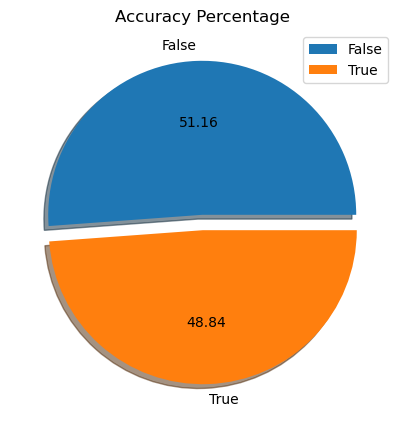

In [49]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
df_known_merchs_pred.groupby('CHECK_TF').size().plot(kind='pie', autopct='%.2f', title='Accuracy Percentage', explode=[0.05, 0.05], legend=True, shadow=True)
ax1.set_ylabel('', size=10);


In [50]:
(df_known_merchs_pred.CHECK_TF).value_counts()

False    12791
True     12209
Name: CHECK_TF, dtype: int64

# Payment Agents VS Merchant Names
- Selected known payment agents
- Checked number of total occurences per agents
- Checked total number of payment agents
- Checked number of transactions with known payment agents
- Defined a function compare payment agents with merchant names
- Created CHECK_MERCH_AGTS to check when agents and merchants are same
- Checked Totals for different situations

In [51]:
df_known_payment_agents = df_known_merchs.copy(deep=True)
# Known payment agent names
df_known_payment_agents = df_known_payment_agents.loc[df_known_payment_agents['AFS_PAYMENT_AGENTS'] != 'Unknow Payment Agent']
df_known_payment_agents

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
875005,T5cf2763281ae3c9993bd13a63d4cfd2b,Bill payment Withdrawal %%%%% Roku for Peacock TV LL 4899 (2023-01-05) 816-*7 DE *99,ROKU,ROKU,True
838148,T98846c544f9e300c973739b3d43ceb22,ACH Withdrawal %%%%% COMPANY:PAYPAL INST XFER ID:9PLAYSTATION,PAYPAL,PLAYSTATION,True
348643,Tfd359741913d34308d80dd8f5cf1a270,POS PURCHASE DD DOORDASH %%%%% CHICK-FIL *1040 CA 0000 *****6612 07/30,DOORDASH,CHICK-FIL-A,True
320609,Tafbc4d83225b3e6ab40b23f064b02382,POS Withdrawal (FIS) DD %%%%% DOORDASH CHI DD DOORDASH CHIPOTL 855-973-1040 CA(6269),DOORDASH,CHIPOTLE MEXICAN,True
1430754,Td7f7cc9e33293455969481e2518ceeae,POS Withdrawal GOOGLE *Word %%%%% Find 855-836-3987 CAUS,GOOGLE,GOOGLE,True
...,...,...,...,...,...
561382,Tf994be00d30b3400b1df10b37e95a96f,DDA PUR DAIRY QUEE %%%%% DAIRY QUEEN OLO #12 *1089 MI *,OLO,DAIRY QUEEN,True
1421529,T0ea091dcc32b3337bfe02178b010144c,Withdrawal DEBIT CARD %%%%% DD DOORDASH APPLEBEES 303 2ND STREET 85597 Date 01/25/23 4 *141 3 5812 %% Card 15 #6748 %% MCC 5812,DOORDASH,APPLEBEE'S,True
138445,T20cbca946d8e3c4da69014b490be001d,Withdrawal Debit PAYPAL %%%%% *PLAYSTATIO 402-935-7733 CAUS,PAYPAL,PLAYSTATION,True
898839,T43b4ab1e41323b7fb01e011c096e4d49,PAYPALSI77 PAYPAL INST XFER 11/03/22 ID #-TARGETCORPO %%%%% nan,PAYPAL,TARGET,True


In [52]:
print('Number of total occurences per payment agents:\n', (df_known_payment_agents.AFS_PAYMENT_AGENTS).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Number of total occurences per payment agents:
 GOOGLE             36.8%
PAYPAL             24.6%
DOORDASH           13.7%
APPLE CASH          6.2%
ROKU                4.8%
SQUARE              4.5%
GRUBHUB.COM         3.3%
OLO                 2.2%
INSTACART           1.2%
VENMO               0.9%
LEVELUP             0.9%
SQUARE CASH APP     0.9%
PRICELINE           0.1%
Name: AFS_PAYMENT_AGENTS, dtype: object


In [53]:
print('Total number of payment agents:\n',len(df_known_payment_agents.AFS_PAYMENT_AGENTS.unique()))

Total number of payment agents:
 13


In [54]:
print('Number of transactions with known payment agents:\n',len(df_known_payment_agents))

Number of transactions with known payment agents:
 820


In [55]:
# Function to compare payment agent names with merchant names
def compare_occurences(agent, merchant):
    agent = agent.split()
    merchant = merchant.split()
    # Conditions to check if words are in transaction strings
    if (merchant in agent or agent in merchant or
        (any(item in merchant for item in agent)) or
        (merchant[:3] in agent)):
        return True
    else:
        return False

In [56]:
# Checking if merchant names and payment agents are same
df_known_payment_agents['CHECK_MERCH_AGTS'] = df_known_payment_agents.apply(lambda x: compare_occurences(x.AFS_MECHANT_NAMES, x.AFS_PAYMENT_AGENTS), axis=1)
df_known_payment_agents.head()

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,CHECK_MERCH_AGTS
875005,T5cf2763281ae3c9993bd13a63d4cfd2b,Bill payment Withdrawal %%%%% Roku for Peacock TV LL 4899 (2023-01-05) 816-*7 DE *99,ROKU,ROKU,True,True
838148,T98846c544f9e300c973739b3d43ceb22,ACH Withdrawal %%%%% COMPANY:PAYPAL INST XFER ID:9PLAYSTATION,PAYPAL,PLAYSTATION,True,False
348643,Tfd359741913d34308d80dd8f5cf1a270,POS PURCHASE DD DOORDASH %%%%% CHICK-FIL *1040 CA 0000 *****6612 07/30,DOORDASH,CHICK-FIL-A,True,False
320609,Tafbc4d83225b3e6ab40b23f064b02382,POS Withdrawal (FIS) DD %%%%% DOORDASH CHI DD DOORDASH CHIPOTL 855-973-1040 CA(6269),DOORDASH,CHIPOTLE MEXICAN,True,False
1430754,Td7f7cc9e33293455969481e2518ceeae,POS Withdrawal GOOGLE *Word %%%%% Find 855-836-3987 CAUS,GOOGLE,GOOGLE,True,True


- Checked how many times merchant names and payment agents are same
- Checked how many time merchant names and payment agents are different
- Checked total number of transactions with known agents

In [57]:
print('Same merchant names and payment agents:\n',len(df_known_payment_agents.loc[df_known_payment_agents['CHECK_MERCH_AGTS']==True]))

Same merchant names and payment agents:
 372


In [58]:
print('Merchant names and payment agents are diferent:\n',len(df_known_payment_agents.loc[df_known_payment_agents['CHECK_MERCH_AGTS']==False]))

Merchant names and payment agents are diferent:
 448


In [59]:
print('Number of rows with known Agents:\n',len(df_known_payment_agents))

Number of rows with known Agents:
 820


In [60]:
df_known_payment_agents

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,CHECK_MERCH_AGTS
875005,T5cf2763281ae3c9993bd13a63d4cfd2b,Bill payment Withdrawal %%%%% Roku for Peacock TV LL 4899 (2023-01-05) 816-*7 DE *99,ROKU,ROKU,True,True
838148,T98846c544f9e300c973739b3d43ceb22,ACH Withdrawal %%%%% COMPANY:PAYPAL INST XFER ID:9PLAYSTATION,PAYPAL,PLAYSTATION,True,False
348643,Tfd359741913d34308d80dd8f5cf1a270,POS PURCHASE DD DOORDASH %%%%% CHICK-FIL *1040 CA 0000 *****6612 07/30,DOORDASH,CHICK-FIL-A,True,False
320609,Tafbc4d83225b3e6ab40b23f064b02382,POS Withdrawal (FIS) DD %%%%% DOORDASH CHI DD DOORDASH CHIPOTL 855-973-1040 CA(6269),DOORDASH,CHIPOTLE MEXICAN,True,False
1430754,Td7f7cc9e33293455969481e2518ceeae,POS Withdrawal GOOGLE *Word %%%%% Find 855-836-3987 CAUS,GOOGLE,GOOGLE,True,True
...,...,...,...,...,...,...
561382,Tf994be00d30b3400b1df10b37e95a96f,DDA PUR DAIRY QUEE %%%%% DAIRY QUEEN OLO #12 *1089 MI *,OLO,DAIRY QUEEN,True,False
1421529,T0ea091dcc32b3337bfe02178b010144c,Withdrawal DEBIT CARD %%%%% DD DOORDASH APPLEBEES 303 2ND STREET 85597 Date 01/25/23 4 *141 3 5812 %% Card 15 #6748 %% MCC 5812,DOORDASH,APPLEBEE'S,True,False
138445,T20cbca946d8e3c4da69014b490be001d,Withdrawal Debit PAYPAL %%%%% *PLAYSTATIO 402-935-7733 CAUS,PAYPAL,PLAYSTATION,True,False
898839,T43b4ab1e41323b7fb01e011c096e4d49,PAYPALSI77 PAYPAL INST XFER 11/03/22 ID #-TARGETCORPO %%%%% nan,PAYPAL,TARGET,True,False
